# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [55]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [56]:
# Define transforms
## YOUR CODE HERE ##
training_transforms = [
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
]

testing_transforms = [
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
]

training_transform = transforms.Compose(training_transforms)
testing_transform = transforms.Compose(testing_transforms)

# Create training set and define training dataloader
## YOUR CODE HERE ##
full_dataset = torchvision.datasets.CIFAR10('./data', transform=training_transform, download=True)
total_size = len(full_dataset)

train_size = int(0.9 * total_size)
valid_size = total_size - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(full_dataset, [train_size, valid_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Create test set and define test dataloader
## YOUR CODE HERE ##
testing_datasets = torchvision.datasets.CIFAR10('./data', transform=testing_transform, download=True, train=False)
testloader = torch.utils.data.DataLoader(testing_datasets, batch_size=32, shuffle=False)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [57]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].


cat


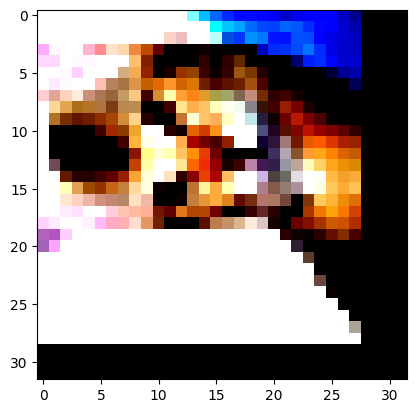

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].


truck


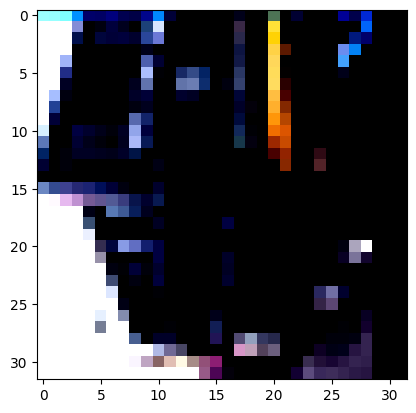

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.514088].


car


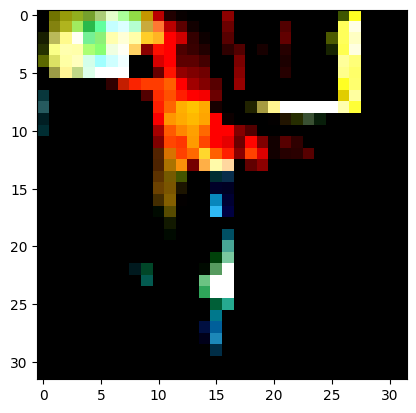

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.300854].


bird


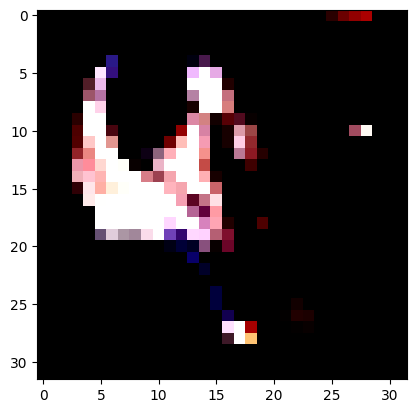

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..1.7386913].


frog


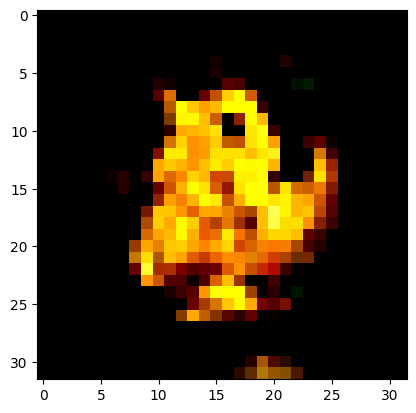

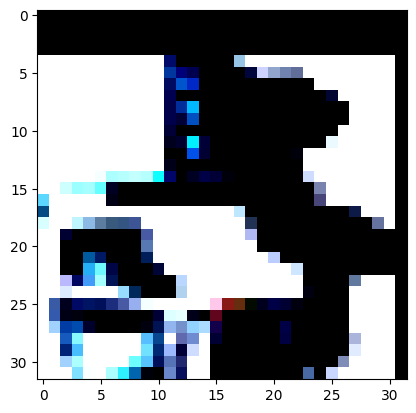

cat


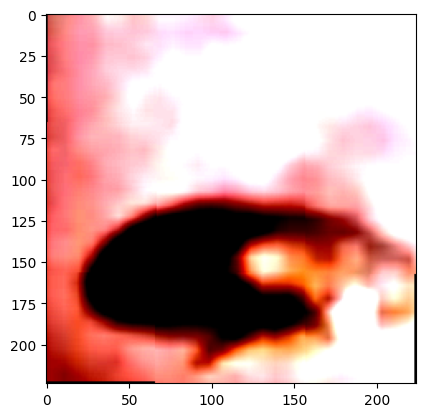

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.65618].


cat


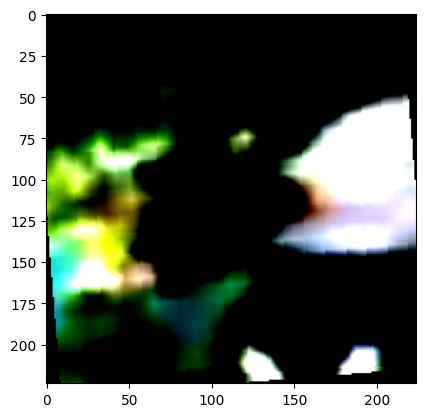

In [58]:
# Explore data
## YOUR CODE HERE ##
show5(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [59]:
## YOUR CODE HERE ##
class Cifar10CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(512 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 10)
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        x = x.view(-1, 512 * 2 * 2)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc2(x), dim=1)
        
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [60]:
## YOUR CODE HERE ##
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
elif torch.cuda.is_available():
    torch.cuda.empty_cache()

model = Cifar10CNN()
learning_rate = 0.1

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [62]:
## YOUR CODE HERE ##
training_losses, validation_losses, accuracy = [], [], []
epochs = 100
stagnation_counter = 0
patience = 10
best_weights = {}
steps = 0
stop_training = False
validate_every=100
best_loss = float('inf')

for e in range (0, epochs):
    current_epoch = e
    train_loss = 0

    if stop_training:
        break

    print("Epoch {}/{}... ".format(e, epochs))

    for image, label in trainloader:
        image, label = image.to(device), label.to(device)
        steps += 1
        logps = model.forward(image)
        loss = criterion(logps, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if steps % validate_every == 0:
            valid_loss = 0
            acc = 0
            with torch.no_grad():
                model.eval()
                for image, label in validloader:
                    image, label = image.to(device), label.to(device)
                    logps = model.forward(image)
                    loss = criterion(logps, label)
                    valid_loss += loss.item()

                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == label.view(*top_class.shape)
                    acc += torch.mean(equals.type(torch.FloatTensor)).item()

            training_losses.append(train_loss / (validate_every))
            validation_losses.append(valid_loss / len(validloader))
            accuracy.append( acc / len(validloader))

            print("Training Loss: {:.3f}.. ".format(training_losses[-1]),
                  "Validation Loss: {:.3f}.. ".format(validation_losses[-1]),
                  "Validation Accuracy: {:.3f}".format(acc / len(validloader)))

            # Early stopping to prevent over-fitting and degrading performance
            if valid_loss < best_loss:
                best_loss = valid_loss
                stagnation_counter = 0
    
                # best_weights = {k: v.clone() for k, v in model.state_dict().items()}       
            else:
                stagnation_counter += 1

            train_loss = 0
            model.train()

        if stagnation_counter > patience:
            print("Stopping Early")
            stop_training = True
            break

Epoch 0/100... 
Training Loss: 1.377..  Validation Loss: 1.473..  Validation Accuracy: 0.469
Training Loss: 1.378..  Validation Loss: 1.353..  Validation Accuracy: 0.510
Training Loss: 1.376..  Validation Loss: 1.296..  Validation Accuracy: 0.533
Training Loss: 1.389..  Validation Loss: 1.185..  Validation Accuracy: 0.580
Training Loss: 1.342..  Validation Loss: 1.436..  Validation Accuracy: 0.492
Training Loss: 1.382..  Validation Loss: 1.194..  Validation Accuracy: 0.566
Training Loss: 1.351..  Validation Loss: 1.217..  Validation Accuracy: 0.540
Training Loss: 1.291..  Validation Loss: 1.233..  Validation Accuracy: 0.549
Training Loss: 1.290..  Validation Loss: 1.094..  Validation Accuracy: 0.600
Training Loss: 1.268..  Validation Loss: 1.216..  Validation Accuracy: 0.560
Training Loss: 1.275..  Validation Loss: 1.134..  Validation Accuracy: 0.583
Training Loss: 1.245..  Validation Loss: 1.128..  Validation Accuracy: 0.580
Training Loss: 1.252..  Validation Loss: 1.165..  Validation

Plot the training loss (and validation loss/accuracy, if recorded).

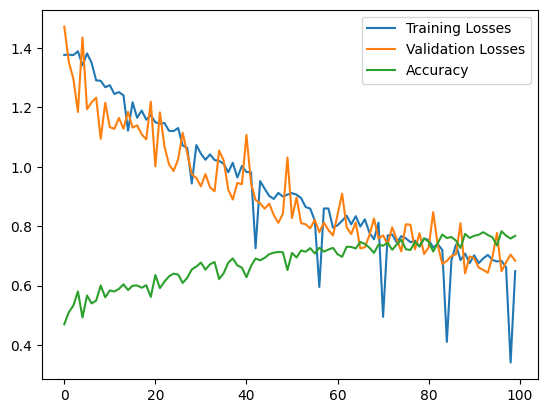

In [63]:
## YOUR CODE HERE ##
plt.plot(training_losses, label='Training Losses')
plt.plot(validation_losses, label='Validation Losses')
plt.plot(accuracy, label='Accuracy')
plt.legend()

plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [64]:
## YOUR CODE HERE ##
# TODO: Do validation on the test set
test_loss = 0
acc = 0
with torch.no_grad():
    model.eval()
    for image, label in testloader:
        image, label = image.to(device), label.to(device)
        logps = model.forward(image)
        loss = criterion(logps, label)
        test_loss += loss.item()

        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == label.view(*top_class.shape)
        acc += torch.mean(equals.type(torch.FloatTensor)).item()

print("Test Loss: {:.3f}.. ".format(test_loss / len(testloader)),
      "Test Accuracy: {:.3f}".format(acc / len(testloader)))

Test Loss: 0.641..  Test Accuracy: 0.781


## Saving your model
Using `torch.save`, save your model for future loading.

In [65]:
## YOUR CODE HERE ##
# TODO: Save the checkpoint
def save_checkpoint(checkpoint_file_path):
    checkpoint = {
                  'learning_rate': learning_rate,
                  'epochs': epochs,
                  'accuracy': accuracy[-1],
                  'training_losses': np.sum(training_losses),
                  'validation_losses': np.sum(validation_losses),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'model_state_dict': model.state_dict()}
    torch.save(checkpoint, checkpoint_file_path)

save_checkpoint('checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Based on the evaluation results, I recommend building a custom image classification solution rather than buying an off-the-shelf product. This custom CNN achieved 78.1% test accuracy, exceeding the 70% target by a significant margin and matching the performance of established benchmark models from 2010. The model trained efficiently in approximately 7 epochs with early stopping, demonstrating that we can develop production ready solutions without requiring extensive computational resources or training time. Additionally, the model architecture is lightweight enough to run on consumer-grade hardware while maintaining strong performance, which translates to low deployment and operational costs.

From a strategic perspective, building our own solution provides several critical advantages. We maintain full control over the model architecture and can customize it for specific use cases as requirements evolve. There are no vendor dependencies, API rate limits, or recurring subscription costs, and all data processing happens within our infrastructure, ensuring complete privacy and security. Unless future requirements demand state-of-the-art accuracy exceeding 90%, purchasing an external solution would be an unnecessary expense.